In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import datetime

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
startTime = datetime.datetime.now()

In [ ]:
torch.manual_seed(1)

In [ ]:
batch_size = 16

In [ ]:
# Veri setlerini yükleme
train_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_validation.csv')

# Model eğitme
from torch.utils.data import DataLoader, TensorDataset
train_inputs = train_df.drop('Cured', axis=1).values
train_labels = train_df['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = val_df.drop('Cured', axis=1).values
val_labels = val_df['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = test_df.drop('Cured', axis=1).values
test_labels = test_df['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Model tanımlama
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        #Ilk hidden layer’da 100, ikinci hidden layer’da 50 nöron olsun
        self.fc1 = nn.Linear(len(train_df.columns) - 1, 100) 
        self.fc2 = nn.Linear(100, 50) 
        self.fc3 = nn.Linear(50, 2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        output = nn.functional.relu(self.fc1(x))
        output = nn.functional.relu(self.fc2(output))
        output = self.fc3(output)
        return self.sigmoid(output)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel().to(device)

In [ ]:
#Loss function ve optimizer tanımlama
criterion=nn.CrossEntropyLoss()

In [ ]:
# Train function tanımlama
def train(model, criterion, train_loader, valid_loader, num_epochs):
    lrate=0.01
    for epoch in range(num_epochs):
       # Model eğitimi
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer = optim.SGD(model.parameters(), lr=lrate).zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer = optim.SGD(model.parameters(), lr=lrate).step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_loss /= len(train_loader)
        train_accuracy = 100. * correct / total
        loss_list.append(train_loss)

       # Değerlendirme
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_loss /= len(valid_loader)
        val_accuracy = 100. * val_correct / val_total
        val_loss_list.append(val_loss)  
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}")
        if(train_loss<0.4):
          lrate += 0.01
          if(train_loss>0.4):
            lrate -= 0.01
        if(val_loss<0.4):
          lrate += 0.01
          if(val_loss>0.4):
            lrate -= 0.01

num_epochs = 90
loss_list = []
val_loss_list = []
break_value=train(model, criterion, train_loader, val_loader, num_epochs)

Epoch [1/90], Train Loss: 0.6421, Train Acc: 67.65, Val Loss: 0.5813, Val Acc: 77.39
Epoch [2/90], Train Loss: 0.5763, Train Acc: 76.36, Val Loss: 0.5299, Val Acc: 82.17
Epoch [3/90], Train Loss: 0.5395, Train Acc: 79.95, Val Loss: 0.4998, Val Acc: 84.39
Epoch [4/90], Train Loss: 0.5035, Train Acc: 83.15, Val Loss: 0.4604, Val Acc: 88.54
Epoch [5/90], Train Loss: 0.4834, Train Acc: 84.58, Val Loss: 0.4523, Val Acc: 87.90
Epoch [6/90], Train Loss: 0.4701, Train Acc: 85.94, Val Loss: 0.4346, Val Acc: 89.81
Epoch [7/90], Train Loss: 0.4637, Train Acc: 86.58, Val Loss: 0.4258, Val Acc: 91.40
Epoch [8/90], Train Loss: 0.4465, Train Acc: 87.78, Val Loss: 0.4226, Val Acc: 91.40
Epoch [9/90], Train Loss: 0.4416, Train Acc: 89.14, Val Loss: 0.4078, Val Acc: 92.04
Epoch [10/90], Train Loss: 0.4349, Train Acc: 88.82, Val Loss: 0.4152, Val Acc: 90.45
Epoch [11/90], Train Loss: 0.4354, Train Acc: 88.98, Val Loss: 0.4018, Val Acc: 92.99
Epoch [12/90], Train Loss: 0.4298, Train Acc: 89.46, Val Loss: 

In [ ]:
from sklearn.metrics import  accuracy_score, precision_score, f1_score,recall_score

# Modeli değerlendirme modunda ayarla
model.eval()

# Test seti üzerinde döngüye gir ve tahminler yap
with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()

# Performans metriklerini hesapla
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.4974
Precision: 0.7500
Recall: 0.4974
F1 Score: 0.3305


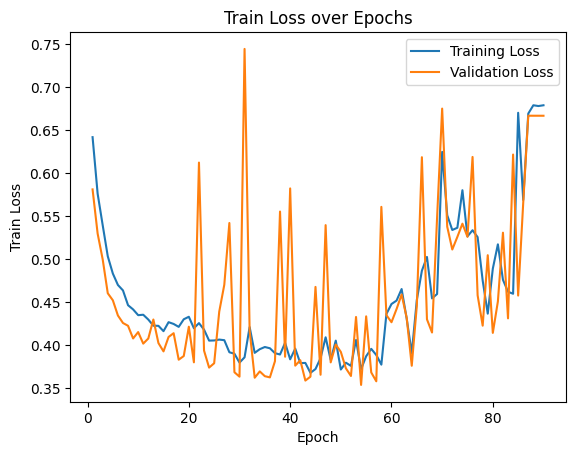

In [ ]:
# Train Loss over Epochs figürü çiz
plt.figure()
break_value = num_epochs+1 if break_value is None else break_value
plt.plot(range(1, break_value), loss_list, label= "Training Loss")
plt.plot(range(1, break_value), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
endTime = datetime.datetime.now()
print("Başlangıç Zamanı: ", endTime, "\nBitiş Zamanı: ", endTime, "\nToplam Çalışma Süresi:", endTime-startTime , "\nÇalışma Ortamı: ", str(device).upper())

Başlangıç Zamanı:  2023-04-09 11:51:10.523704 
Bitiş Zamanı:  2023-04-09 11:51:10.523704 
Toplam Çalışma Süresi: 0:00:10.268485 
Çalışma Ortamı:  CPU
